# ACIDES tutorial

This is a tutorial on how to use ACIDES. This Jupyter Notebook file (ACIDES_tutorial.ipynb) as well as the ACIDES module file (ACIDES_module.py) can be downloaded from https://github.com/nemoto-lab/ACIDES/. Please refer to the article (link) for the technical details. 

## 1. Importing ACIDES_module

We can either place the module file (ACIDES_module.py) in the same directory as the Jupyter Notebook file (ACIDES_tutorial.ipynb) or specify the path to the module file by using sys.path.append("path_to_ACIDES_module"). Below we assume that we are at ACIDES/tutorial directory. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy
from importlib import reload
import os
import sys
sys.path.append(".")
sys.path.append("../module/")
import ACIDES_module
from ACIDES_module import ACIDES
from ACIDES_module import ACIDES_FIGURE_AVERAGE
import warnings
warnings.filterwarnings("ignore")

##   2. Preparing the data

The count data files for Data-A through Data-G (refer to Table 1 of the article), which can be used as input data for ACIDES, are available for download at the following link: https://www.dropbox.com/scl/fi/wxe8ip8ib769qd06d3geg/DataAtoG.zip?rlkey=dj4j9urd8co4r8y8djngtimit&dl=0
Here we will be using Data-B, which employs the yeast two-hybrid assay. We extract rep1.csv from Data-B and place it in the working directory. This file can be read using pandas:

In [2]:
data_set = pd.read_csv('./rep1.csv',index_col=0)

data_set is a matrix, whose entries represent the NGS counts for each variant (row) and for each round (column):

In [3]:
data_set

,c_0,c_18,c_37,c_45
variant_0,10578861.0,1688739.0,1958501.0,1584951.0
variant_1,408.0,41.0,19.0,10.0
variant_2,52.0,7.0,3.0,1.0
variant_3,359.0,48.0,71.0,28.0
variant_4,807.0,98.0,47.0,43.0
...,...,...,...,...
variant_26738,623.0,91.0,62.0,89.0
variant_26739,26.0,0.0,0.0,0.0
variant_26740,93.0,13.0,8.0,0.0
variant_26741,80.0,5.0,0.0,3.0


Additionally, the time values for each round need to be defined.

In [4]:
t_rounds = np.array([0,18,37,45])/45

The time values for each round can be represented as integers ([0,1,2,3,...]). Alternatively, you can also normalize the time values so that the maximum t_rounds value is equal to 1. Note that, in this particular dataset, the yeast two-hybrid screening (Y2H) is utilized, which means that the intervals between different rounds may not necessarily be the same.

##   3. Performing ACIDES

We will now perform ACIDES. To do so, we first need to fix parameters $\alpha$ and $\beta$, which specify the shape of the probability distribution that describes the randomness of the experiments (please refer to the first paragraph of the RESULTS or the model in the METHOD section of the article). It is worth noting that the larger the values of $\alpha$ or $\beta$, the smaller the randomness of the distribution becomes. In the limit of $\alpha\rightarrow \infty$ or $\beta\rightarrow \infty$, the probability distribution becomes the Poisson distribution. There are two ways to determine $\alpha$ and $\beta$: (i) using a maximum likelihood approach (with the aid of a ACIDES class, as explained below), or (ii) using the values obtained from different experiments as an approximation. In this tutorial, we will set $\alpha=0.87$ and $\beta=0.25$ and proceed with the analysis. Later on, using a maximum likelihood approach, we will derive these values.

In [5]:
## The name of the data
save_name = "Y2H_1"
  
## prepare a random number generator object 
seed_num = 123412
rng = np.random.RandomState(seed_num)

## make a directory in which the results will be saved
try:
  os.mkdir(save_name)
except:
  pass

Below, para_n_jobs refers to the number of cores to be used. (The number of cores refers to the number of processing units available for this program to use. Using more cores can result in faster program execution.) With 6 cores, this computation will take approximately 2 minutes. To specify the values of $\alpha$ and $\beta$, use Fixed_abneg. Note that when specifying these values, negbin_iterate and average_range_0 must be set to 1.

In [6]:
reload(ACIDES_module)
from ACIDES_module import ACIDES
fit = ACIDES(Inference_type='Negbin',
                 theta_term_yes='yes',
                 t_rounds=t_rounds.copy(),
                 folder_name = save_name,
                 random_num=rng,
                 para_n_jobs = 6)
fit.fit(_data_set_=data_set.copy(),negbin_iterate=1, Fixed_abneg=[0.87,0.25])
fit.fit_after_fixing_parameters(average_range_0 = 1)

fit START!
0
fit DONE!
fit_after_fixing_parameters START!
fit_after_fixing_parameters END!


## 4. Analyzing ACIDES results

The results of the fitting process are stored in the directory (save_name). To extract information from these results, we will use a ACIDES_FIGURE_AVERAGE class. Once again, n_jobs refers to the number of cores to be used.

In [7]:
reload(ACIDES_module)
from ACIDES_module import ACIDES_FIGURE_AVERAGE
self = ACIDES_FIGURE_AVERAGE(Inference_type = 'Negbin',
                              howmany_average = 1,
                              save_folder = save_name,
                              t_rounds = t_rounds.copy(),
                              n_jobs = 4)

The scores and confidence intervals (CIs) for each variant obtained from the fitting process are stored in the following array as "a_inf" (scores) and "a_inf_err" (CIs: 2 $\times$ standard deviations):

In [8]:
self.dummy_dictionary["data_all"]

,a_inf,a_inf_err,b_inf,b_inf_err
variant_0,0.011373,0.007141,-1.178697,0.003459
variant_1,-1.485581,0.912753,-11.321703,0.298770
variant_2,-0.949850,1.639422,-13.305163,0.696642
variant_3,-0.251799,0.683762,-11.452378,0.312758
variant_4,-1.073895,0.615376,-10.645455,0.221700
...,...,...,...,...
variant_26738,-0.286186,0.559001,-10.916374,0.248912
variant_26739,-25.975719,559.360877,-14.001896,0.965037
variant_26740,-1.559547,1.675997,-12.729206,0.545231
variant_26741,-1.997765,2.046125,-12.938371,0.607807


Sorting the scores of all variants in descending order gives us a variant rank, which we refer to as the "naive rank." However, due to statistical errors in the scores, the obtained rank is generally biased. To correct for this bias, ACIDES uses \textit{in-silico} simulations based on the confidence intervals of the scores to re-estimate the rank with 95%-CIs. We refer to this as the "corrected rank". To generate the plot of the corrected rank against the naive rank (corresponding to Fig.2A-2G), use the following function. Note that this function takes approximately 7 minutes with 4 cores.

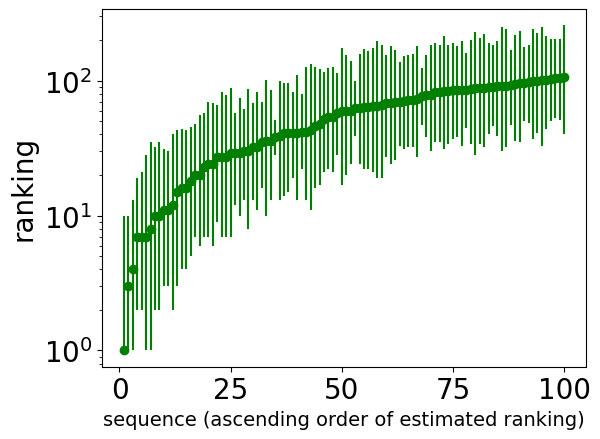

In [9]:
%matplotlib inline
self.Ranking_probability_based_on_ai(use_saved_data = False, all_th = 5000)

Finally, we compute the Rank Robustness (RR) based on the obtained corrected rank. RR represents the percentage of the top 50 variants identified in the naive rank that also appear in the top 50 of the corrected rank. This measure indicates the quality of the selection convergence and ranges from 0 to 1, with a low value indicating that the variants have not been selected enough, and therefore, more rounds, deeper NGS sampling, or more replicates are necessary. To compute RR in ACIDES, use the following function:

In [10]:
self.Experimental_reliability_(all_th = 5000,Total_num = 50)

RR =  0.82432


## 5. Estimating $\alpha$ and $\beta$. 

In order to estimate $\alpha$ and $\beta$, we again use ACIDES.fit. This time, it will take around 20 minutes with 6 cores. Determining $\alpha$ and $\beta$ is an iterative process (see Fig.S2 for details). negbin_iterate specifies the number of iterations. We can see that after the five iterations, the values of $\alpha$ and $\beta$ have almost converged.

In [11]:
reload(ACIDES_module)
from ACIDES_module import ACIDES
fit = ACIDES(Inference_type='Negbin',
                 theta_term_yes='yes',
                 t_rounds=t_rounds.copy(),
                 folder_name = save_name,
                 random_num=rng,
                 para_n_jobs = 6)
fit.fit(_data_set_=data_set.copy(),negbin_iterate=8)

fit START!
0
0.5626088845225958 1.081642980396438
1
0.7197317402763899 0.65966389256076
2
0.7994728907331808 0.44305606874856834
3
0.8358968117513093 0.3416157590271214
4
0.8553396877524212 0.29208200881242646
5
0.8664619397015896 0.2637692479274815
6
0.8700779915402177 0.2553976611537113
7
0.871747711603545 0.25104360818865695
fit DONE!


## 6. Benchmark of ACIDES against DiMSum, Enrich2 and other approaches (Fig. 5 generation)

As an application, we will provide the script to generate Fig.5 of the article using ACIDES. 

We're testing the accuracy of error predictions made by ACIDES against 5 different models, including DimSum and Enrich2, using 12 datasets. These 12 datasets can be downloaded from the following link: https://www.dropbox.com/s/egkzvzkxlzpr1fe/12dataset.zip?dl=0 (taken from DimSum Github page https://github.com/lehner-lab/dimsumms). Please download and extract the "12datasets" foldrer from the dropbox link and place it in the same directory as the "ACIDES_tutorial.ipynb" file. Below, "Data_file_name" stores the names of the data text files, "Data_name" stores the names of each data text file (by removing the file extension ".txt" from "Data_name"), "Data_" is a list storing count data for each "Data_name", and "Num_rep" stores the number of replicated experiments for each dataset. Finally, "Initial_library_same_dict" specifies whether each dataset shares the initial library. 

In [12]:
Dataplace = "."
Data_file_name = ['GRB2_GPD.txt', 'FOScis.txt', 'tRNA_selDMSO.txt', 'TDP43_332.txt', 'GRB2_CYC.txt', 'tRNA_sel23.txt', 'GB1.txt', 'tRNA_sel37.txt', 'tRNA_sel30.txt', 'TDP43_290.txt', 'FOSJUN.txt', 'tRNA_Phylogeny.txt']
Data_name = list(range(len(Data_file_name)))
for i in range(len(Data_file_name)):
    Data_name[i] = Data_file_name[i][:Data_file_name[i].find(".")]
Data_ = list(range(len(Data_name)))
Num_rep = list(range(len(Data_name)))
for i in range(len(Data_file_name)):
    Data_[i] = pd.read_csv(Dataplace + "/12dataset/" + Data_file_name[i],sep=' ')
    Rep_dummy = 0
    for j in Data_[i].columns:
        if j.find("input") != -1:
            Rep_dummy += 1
    Num_rep[i] = Rep_dummy
t_rounds = np.array([0,1])
## In the data "TDP43_290", the replicate number is fixed.
Data_[np.where(np.array(Data_name) == 'TDP43_290')[0][0]].columns = ['WT', 'Nmut', 'input1', 'input2', 'input3', 'output1', 'output2','output3']

Initial_library_same_dict = {0 : None, 1 : None, 2 : "same", 3 : None, 4 : None, 5 : "same", 6 : "same", 7 : "same", 8 : "same", 9 : None, 10: None, 11 : None} 

We will be comparing ACIDES against 5 other algorithms (DiMSum, Enrich2, the count-based model, the Bayesian regularization model, and the standard-deviation based model) using the cross validation method used in [Faure 2020]. For more details, please refer to the Methods section of the manuscript. We used the script provided at https://github.com/lehner-lab/dimsumms to generate these cross-validation results for the five other algorithms. You can download the results from this link: https://www.dropbox.com/s/wpkrsfelfv5tymw/5algorithms_results.zip?dl=0 Please download and extract the "5algorithms_results" folder from the dropbox link and place it in the same directory as the "ACIDES_tutorial.ipynb" file. 

Next, we'll begin analyzing each dataset (i=0,...,11) using ACIDES. This process, which uses the "_12_dataset_fitting" function, will take around 1 hour with 8 cores. If you'd like to skip this computation, you can download and extract the "_12_dataset_fitting" folder from the following link: https://www.dropbox.com/s/itq2coiirqezrts/_12_dataset_fitting.zip?dl=0
Please place this folder in the same directory as the "ACIDES_tutorial.ipynb" file. By doing so, you'll be able to proceed directly to the subsequent step, where you'll generate the figure using the "Figure_12datasets_6method_comparison" function.

In [13]:
reload(ACIDES_module)
from ACIDES_module import ACIDES
_self_ = ACIDES(Inference_type='Negbin',
                 theta_term_yes='yes',
                 t_rounds=t_rounds)
_self_._12_dataset_fitting(Initial_library_same_dict,Num_rep,Data_name,Data_)

GRB2_GPD None
FOScis None
tRNA_selDMSO same
TDP43_332 None
GRB2_CYC None
tRNA_sel23 same
GB1 same
tRNA_sel37 same
tRNA_sel30 same
TDP43_290 None
FOSJUN None
tRNA_Phylogeny None


Finally, the following command will draw a graph to compare 6 different algorihtms using 12 datasets. 

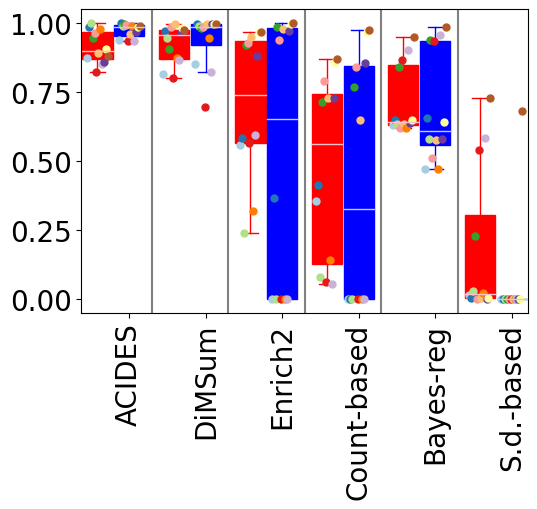

In [14]:
reload(ACIDES_module)
from ACIDES_module import ACIDES
_self_ = ACIDES(Inference_type='Negbin',
                 theta_term_yes='yes',
                 t_rounds=t_rounds)
_self_.Figure_12datasets_6method_comparison(Num_rep, Data_name)